In [1]:
from src.cellpose_segmentation import CellposeTool
from cellpose.metrics import average_precision
from src.data_io import ImageData
import os
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
segmenter = CellposeTool(model_name="cyto3", device=5)
save_dir = '/home/afarhang/data/updated_cellpose_combined_data'



dataset_size = 808

images, masks, image_ids = segmenter.loadCombinedDataset(os.path.join(save_dir, 'val_set/'), dataset_size=dataset_size)
images_test, masks_test, image_ids_test = segmenter.loadCombinedDataset(os.path.join(save_dir, 'test_set/'), dataset_size=dataset_size)
combo_images = images + images_test
combo_masks = masks + masks_test
combo_image_ids = image_ids + image_ids_test

images = ImageData(raw=combo_images, batch_size=dataset_size*2, masks=combo_masks, image_ids=combo_image_ids)


In [2]:

def preprocess_images(images):
        # Function 1: Apply CLAHE to channel 0 (nucleus), controlled contrast stretching on channel 1 (cytoplasm), channel 2 unchanged
        processed_images_list = []
        for img_array in images.raw:
            img = np.copy(img_array)
            output = np.zeros_like(img)
            # Channel 0: CLAHE (for better nucleus contrast)
            ch0 = (img[..., 0] * 255).astype(np.uint8)
            clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            ch0_eq = clahe.apply(ch0)
            output[..., 0] = ch0_eq.astype(np.float32) / 255.0
            # Channel 1: Contrast stretching (clip 1st & 99th percentiles)
            ch1 = img[..., 1]
            p1, p99 = np.percentile(ch1, 1), np.percentile(ch1, 99)
            ch1_stretch = np.clip((ch1 - p1) / (p99 - p1 + 1e-6), 0, 1)
            output[..., 1] = ch1_stretch
            # Channel 2: unchanged
            output[..., 2] = img[..., 2]
            processed_images_list.append(output)
        return ImageData(raw=processed_images_list, batch_size=images.batch_size)

# Let's plot the raw images on top of the preprocessed images

# save fig as preprocessed_images.png
preprocessed_images = preprocess_images(images)


In [3]:
def normalize99(Y, lower=1, upper=99, copy=True, downsample=False):
            '''
            Normalize the image so that 0.0 corresponds to the 1st percentile and 1.0 corresponds to the 99th percentile.
            Args:
                Y (ndarray): The input image (for downsample, use [Ly x Lx] or [Lz x Ly x Lx]).
                lower (int, optional): The lower percentile. Defaults to 1.
                upper (int, optional): The upper percentile. Defaults to 99.
                copy (bool, optional): Whether to create a copy of the input image. Defaults to True.
                downsample (bool, optional): Whether to downsample image to compute percentiles. Defaults to False.
            Returns:
                ndarray: The normalized image.
            '''
            X = Y.copy() if copy else Y
            X = X.astype("float32") if X.dtype!="float64" and X.dtype!="float32" else X
            if downsample and X.size > 224**3:
                nskip = [max(1, X.shape[i] // 224) for i in range(X.ndim)]
                nskip[0] = max(1, X.shape[0] // 50) if X.ndim == 3 else nskip[0]
                slc = tuple([slice(0, X.shape[i], nskip[i]) for i in range(X.ndim)])
                x01 = np.percentile(X[slc], lower)
                x99 = np.percentile(X[slc], upper)
            else:
                x01 = np.percentile(X, lower)
                x99 = np.percentile(X, upper)
            if x99 - x01 > 1e-3:
                X -= x01 
                X /= (x99 - x01)
            else:
                X[:] = 0
            return X

def expert_preprocess_images(images):
    processed_images_list = []
    for img_array in preprocessed_images.raw:
        processed_images_list.append(normalize99(img_array))
    return ImageData(raw=processed_images_list, batch_size=preprocessed_images.batch_size)

expert_preprocessed_images = expert_preprocess_images(images)



In [4]:
preprocessed_masks = segmenter.predict(preprocessed_images)
expert_preprocessed_masks = segmenter.predict(expert_preprocessed_images)






/home/afarhang/miniconda3/envs/sci-agent/lib/python3.10/site-packages/cellpose/transforms.py:602: UserWarning: 'chan2 (opt)' has value range of ZERO, can instead set chan2 to 0
  warnings.warn(
/home/afarhang/miniconda3/envs/sci-agent/lib/python3.10/site-packages/cellpose/transforms.py:602: UserWarning: 'chan2 (opt)' has value range of ZERO, can instead set chan2 to 0
  warnings.warn(
/home/afarhang/miniconda3/envs/sci-agent/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/afarhang/miniconda3/envs/sci-agent/lib/python3.10/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
no seeds found in get_masks_torch - no masks found.


In [19]:
agent_precision, _, _, _ = average_precision(combo_masks, preprocessed_masks)
expert_precision, _, _, _ = average_precision(combo_masks, expert_preprocessed_masks)
agent_precision = np.array([precis[0].item() for precis in agent_precision])
expert_precision = np.array([precis[0].item() for precis in expert_precision])

print(f"Agent Precison: {agent_precision}")
print(f"Expert Precison: {expert_precision}")


/home/afarhang/miniconda3/envs/sci-agent/lib/python3.10/site-packages/cellpose/metrics.py:132: RuntimeWarning: invalid value encountered in divide
  ap[n] = tp[n] / (tp[n] + fp[n] + fn[n])


Agent Precison: [0.95951414 0.40517241 0.1183432  ... 0.1554054  0.44444445 0.18871595]
Expert Precison: [0.95141703 0.40922189 0.11176471 ... 0.17995444 0.41758242 0.19066148]


In [25]:
precision_advantages = agent_precision - expert_precision

# sort by precision advantage, keep index. 
# Sort from largest to smallest
sorted_precision_advantages = precision_advantages[np.argsort(precision_advantages)[::-1]]
sorted_indices = np.argsort(precision_advantages)[::-1]

# 

In [45]:
acquired_indices = []
for idx, prec_adv in zip(sorted_indices, sorted_precision_advantages):
    if np.isnan(prec_adv):
        continue
    acquired_indices.append(idx)
    if len(acquired_indices) >= 20:
        break
acquired_indices = np.array(acquired_indices)





Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.5269460598254443].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.5182555].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1947066].


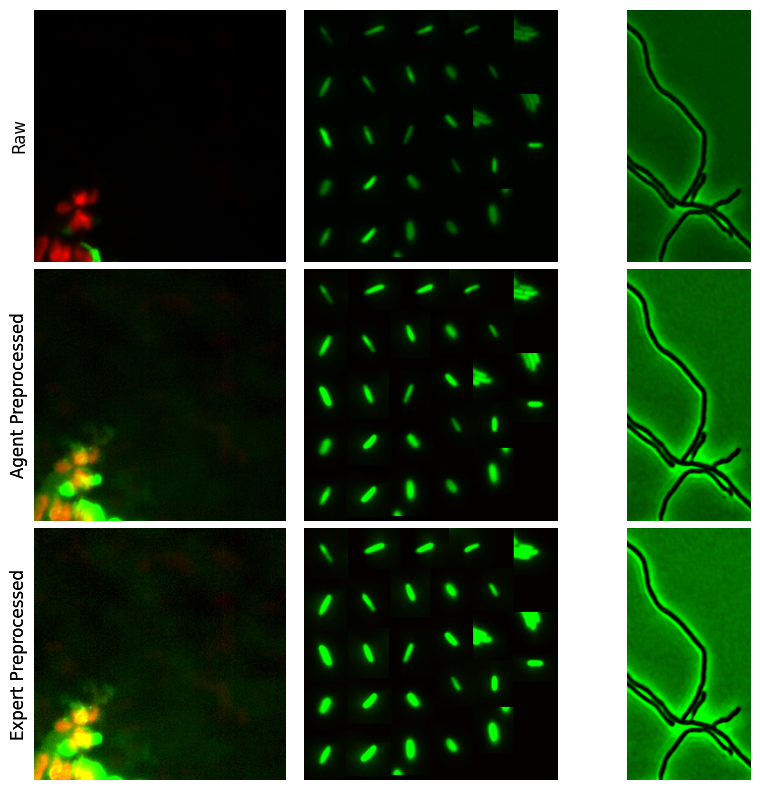

<Figure size 640x480 with 0 Axes>

In [123]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Create figure
fig = plt.figure(figsize=(10, 10))

# Create a gridspec with custom width ratios to bring the right column closer
gs = gridspec.GridSpec(3, 3, figure=fig, 
                     width_ratios=[1, 1, 0.9],  # Make the right column slightly narrower
                     wspace=0.03,  # Small space between columns 1-2
                     hspace=0.03)  # Small space between rows

# Define the row names
names = ["Raw", "Agent Preprocessed", "Expert Preprocessed"]

# Define a function to customize each axis the same way
def setup_axis(row, col, img, ylabel=None):
    ax = fig.add_subplot(gs[row, col])
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Remove the spines (borders) for all subplots to reduce spacing
    for spine in ax.spines.values():
        spine.set_visible(False)
        
    if ylabel:
        ax.set_ylabel(ylabel, fontsize=12)
    return ax

# Plot the images according to your layout
for i in range(3):
    # First column: first image (raw, agent preprocessed, expert preprocessed)
    if i == 0:
        setup_axis(i, 0, images.raw[acquired_indices[0]], names[i])
    else:
        setup_axis(i, 0, images.raw[acquired_indices[0]], names[i])
        
    # Second column: second image (raw, agent preprocessed, expert preprocessed)
    setup_axis(i, 1, images.raw[acquired_indices[1]])
    
    # Third column: third image (raw, agent preprocessed, expert preprocessed)
    setup_axis(i, 2, images.raw[acquired_indices[2]])

# Second row should show preprocessed images
setup_axis(1, 0, preprocessed_images.raw[acquired_indices[0]], names[1])
setup_axis(1, 1, preprocessed_images.raw[acquired_indices[1]])
setup_axis(1, 2, preprocessed_images.raw[acquired_indices[2]])

# Third row should show expert preprocessed images
setup_axis(2, 0, expert_preprocessed_images.raw[acquired_indices[0]], names[2])
setup_axis(2, 1, expert_preprocessed_images.raw[acquired_indices[1]])
setup_axis(2, 2, expert_preprocessed_images.raw[acquired_indices[2]])

# Add space for the y-labels while keeping the figure tight
plt.subplots_adjust(left=0.17, right=0.95)

plt.show()
fig = plt.gcf()


In [114]:
# import numpy as np
# from skimage.exposure import rescale_intensity
# from skimage.segmentation import find_boundaries

# # For your single image with shape (256, 256, 3) and mask with shape (256, 256)
# def create_rgb_overlay(image, mask, color='white'):
#     """
#     Creates an overlay of a segmentation mask on an RGB image
    
#     Args:
#         image: RGB image with shape (256, 256, 3)
#         mask: Segmentation mask with shape (256, 256)
    
#     Returns:
#         numpy.array: Image with segmentation boundary overlay
#     """
#     # Ensure mask is the right shape and has values 0 or 1
#     if len(mask.shape) == 2:
#         # Add a channel dimension to make it (256, 256, 1)
#         mask = np.expand_dims(mask, axis=-1)
    
#     # Find boundaries of the segmentation mask
#     boundary = find_boundaries(mask[..., 0], connectivity=1, mode='inner')
    
#     # Create a copy of the image for overlay
#     overlay_image = np.copy(image)
    
#     # Set boundary pixels to white (or any color you prefer)
#     if color == 'white':
#         array_color = [1, 1, 1]
#     elif color == 'red':
#         array_color = [1, 0, 0]
#     overlay_image[boundary > 0] = array_color  # White boundaries
#     # Alternatively, use a brighter color like yellow:
#     # overlay_image[boundary > 0] = [1, 1, 0]  # Yellow boundaries
    
#     return overlay_image

# overlayed = create_rgb_overlay(preprocessed_images.raw[acquired_indices[0]], preprocessed_masks[acquired_indices[0]], color='white')
# overlayed = create_rgb_overlay(preprocessed_images.raw[acquired_indices[0]], expert_preprocessed_masks[acquired_indices[0]], color='red')

In [115]:
# plt.imshow(overlayed)

In [116]:
# # Plot the top 3 images from the acquired indices. 
# # First row: Raw images
# # Second row: Preprocessed images
# # Third row: Expert preprocessed images
# # fourth row: overlayed segmentation masks
# plt.figure(figsize=(10, 10))
# # Do not show axis ticks
# for i in range(3):
#     img_to_plot = acquired_indices[i]
#     plt.subplot(6,3 ,i+1)
#     plt.imshow(images.raw[img_to_plot])
#     plt.subplot(6,3 ,i+4)
#     plt.imshow(preprocessed_images.raw[img_to_plot])
#     plt.subplot(6,3 ,i+7)
#     plt.imshow(expert_preprocessed_images.raw[img_to_plot])
#     # Plot agent_masks - ground truth masks
#     plt.subplot(6,3 ,i+10)
#     plt.imshow(preprocessed_masks[img_to_plot] - combo_masks[img_to_plot].squeeze())
#     # Plot expert_masks - ground truth masks
#     plt.subplot(6,3 ,i+13)
#     plt.imshow(expert_preprocessed_masks[img_to_plot] - combo_masks[img_to_plot].squeeze())
#     # plot agent - expert masks
#     plt.subplot(6,3 ,i+16)
#     plt.imshow(preprocessed_masks[img_to_plot] - expert_preprocessed_masks[img_to_plot])
# plt.show()
# fig = plt.gcf()


In [113]:
# import matplotlib.pyplot as plt
# import numpy as np
# from skimage.segmentation import find_boundaries
# from skimage.exposure import rescale_intensity

# # Helper function for creating segmentation overlays
# def create_mask_overlay(image, mask, color=[1, 0, 0]):  # Default to red overlay
#     """Creates an overlay of a segmentation mask on an image"""
#     # Ensure image is float32 and in range 0-1
#     if image.dtype != np.float32:
#         image = image.astype(np.float32)
#     if image.max() > 1.0:
#         image = image / 255.0
        
#     # Make sure we have a 3-channel image for RGB overlay
#     if len(image.shape) == 2 or image.shape[2] == 1:
#         image = np.repeat(np.expand_dims(image, axis=-1), 3, axis=-1)
    
#     # Convert mask to binary if not already
#     if len(mask.shape) == 3 and mask.shape[2] == 1:
#         mask = mask.squeeze()
    
#     # Create boundary from mask
#     boundary = find_boundaries(mask > 0.5, connectivity=1, mode='inner')
    
#     # Create overlay
#     overlay = np.copy(image)
#     for c in range(3):
#         overlay[boundary > 0, c] = color[c]
    
#     return overlay

# # Plot the top 3 images from the acquired indices with improved visualization
# plt.figure(figsize=(15, 18))

# # Define different overlay colors for better distinction
# difference_color = [1, 0, 0]    # Red for differences
# positive_diff_color = [0, 1, 0] # Green for positive differences
# negative_diff_color = [0, 0, 1] # Blue for negative differences

# for i in range(3):
#     img_to_plot = acquired_indices[i]
    
#     # Row 1: Raw images
#     plt.subplot(6, 3, i+1)
#     plt.imshow(images.raw[img_to_plot])
#     plt.title(f"Raw Image {img_to_plot}")
#     plt.axis('off')
    
#     # Row 2: Preprocessed images
#     plt.subplot(6, 3, i+4)
#     plt.imshow(preprocessed_images.raw[img_to_plot])
#     plt.title(f"Preprocessed Image {img_to_plot}")
#     plt.axis('off')
    
#     # Row 3: Expert preprocessed images
#     plt.subplot(6, 3, i+7)
#     plt.imshow(expert_preprocessed_images.raw[img_to_plot])
#     plt.title(f"Expert Preprocessed {img_to_plot}")
#     plt.axis('off')
    
#     # Row 4: Agent masks vs ground truth (overlay)
#     plt.subplot(6, 3, i+10)
#     # Create difference mask and overlay
#     diff_mask = preprocessed_masks[img_to_plot] - combo_masks[img_to_plot].squeeze()
#     # For clearer visualization, create a colormap instead of just showing differences
#     plt.imshow(create_mask_overlay(preprocessed_images.raw[img_to_plot], 
#                                  np.abs(diff_mask) > 0.1, 
#                                  difference_color))
#     plt.title("Agent vs GT Mask")
#     plt.axis('off')
    
#     # Row 5: Expert masks vs ground truth (overlay)
#     plt.subplot(6, 3, i+13)
#     # Create difference mask and overlay
#     diff_mask = expert_preprocessed_masks[img_to_plot] - combo_masks[img_to_plot].squeeze()
#     plt.imshow(create_mask_overlay(expert_preprocessed_images.raw[img_to_plot], 
#                                  np.abs(diff_mask) > 0.1, 
#                                  difference_color))
#     plt.title("Expert vs GT Mask")
#     plt.axis('off')
    
#     # Row 6: Agent vs expert masks (overlay with directional coloring)
#     plt.subplot(6, 3, i+16)
#     diff_mask = preprocessed_masks[img_to_plot] - expert_preprocessed_masks[img_to_plot]
    
#     # Create a colored overlay where:
#     # - Red shows where agent predicts but expert doesn't
#     # - Blue shows where expert predicts but agent doesn't
#     base_img = preprocessed_images.raw[img_to_plot].copy()
#     if base_img.dtype != np.float32:
#         base_img = base_img.astype(np.float32)
#     if base_img.max() > 1.0:
#         base_img = base_img / 255.0
        
#     if len(base_img.shape) == 2 or base_img.shape[2] == 1:
#         base_img = np.repeat(np.expand_dims(base_img, axis=-1), 3, axis=-1)
    
#     overlay = np.copy(base_img)
#     # Positive differences (agent predicts more than expert)
#     pos_boundary = find_boundaries((diff_mask > 0.1).astype(np.uint8), connectivity=1, mode='inner')
#     overlay[pos_boundary > 0] = positive_diff_color
    
#     # Negative differences (expert predicts more than agent)
#     neg_boundary = find_boundaries((diff_mask < -0.1).astype(np.uint8), connectivity=1, mode='inner')
#     overlay[neg_boundary > 0] = negative_diff_color
    
#     plt.imshow(overlay)
#     plt.title("Agent vs Expert Mask")
#     plt.axis('off')

# plt.tight_layout()
# plt.show()
# fig = plt.gcf()

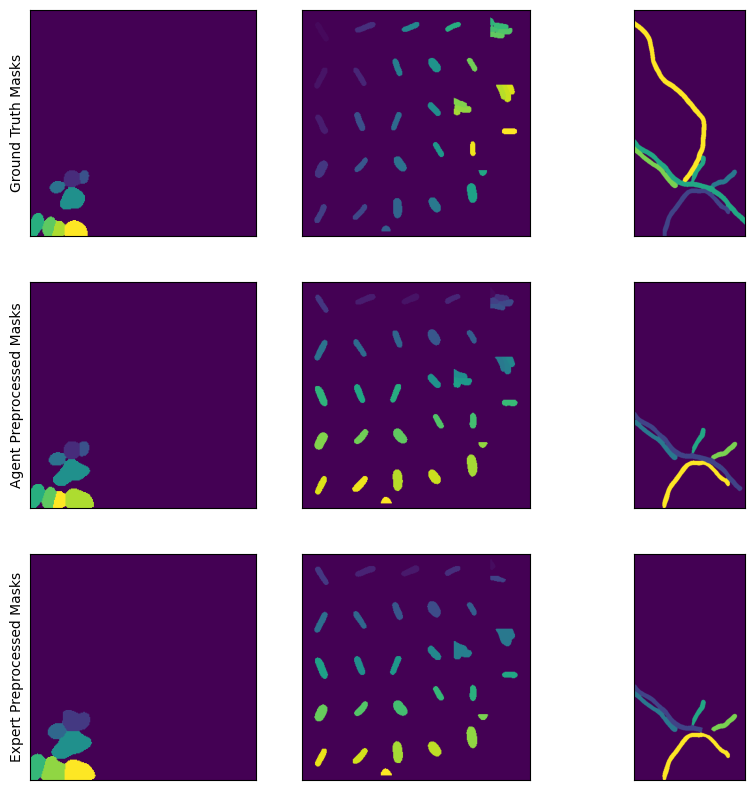

<Figure size 640x480 with 0 Axes>

In [124]:
# big figure
plt.figure(figsize=(10, 10))
# turn off tick labels for all subplots
# plt.xticks([])
# plt.yticks([])
# plot ground truth masks
plt.subplot(3,3,1)
plt.imshow(combo_masks[acquired_indices[0]])
plt.ylabel("Ground Truth Masks")

plt.subplot(3,3,2)
plt.imshow(combo_masks[acquired_indices[1]])
plt.subplot(3,3,3)
plt.imshow(combo_masks[acquired_indices[2]])
# row title: ground truth masks
# next row, plot the preprocessed_masks
plt.subplot(3,3,4)
plt.imshow(preprocessed_masks[acquired_indices[0]])
plt.ylabel("Agent Preprocessed Masks")

plt.subplot(3,3,5)
plt.imshow(preprocessed_masks[acquired_indices[1]])
plt.subplot(3,3,6)
plt.imshow(preprocessed_masks[acquired_indices[2]])
# row title: preprocessed masks
# next row plot the expert_preprocessed_masks
plt.subplot(3,3,7)
plt.imshow(expert_preprocessed_masks[acquired_indices[0]])
plt.ylabel("Expert Preprocessed Masks")

plt.subplot(3,3,8)
plt.imshow(expert_preprocessed_masks[acquired_indices[1]])
plt.subplot(3,3,9)
plt.imshow(expert_preprocessed_masks[acquired_indices[2]])
# row title: expert preprocessed masks
# plt.show()
fig = plt.gcf()

# For all subplots, turn off tick labels
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
plt.show()
fig = plt.gcf()


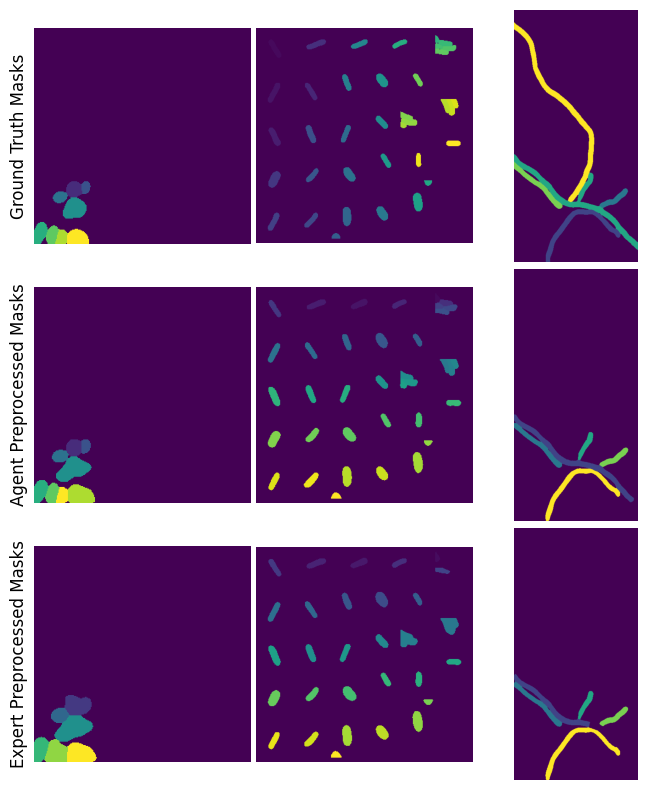

<Figure size 640x480 with 0 Axes>

In [127]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Create figure
fig = plt.figure(figsize=(8, 10))

# Create a gridspec with custom width ratios to bring the right column closer
# The third column gets a smaller width ratio to pull it closer to the center
gs = gridspec.GridSpec(3, 3, figure=fig, 
                     width_ratios=[1, 1, 0.9],  # Make the right column slightly narrower
                     wspace=0.03,  # Small space between columns 1-2
                     hspace=0.03)  # Small space between rows

# Define a function to customize each axis the same way
def setup_axis(row, col, img, ylabel=None):
    ax = fig.add_subplot(gs[row, col])
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Remove the spines (borders) for all subplots to reduce spacing
    for spine in ax.spines.values():
        spine.set_visible(False)
        
    if ylabel:
        ax.set_ylabel(ylabel, fontsize=12)
    return ax

# First row: Ground Truth Masks
setup_axis(0, 0, combo_masks[acquired_indices[0]], "Ground Truth Masks")
setup_axis(0, 1, combo_masks[acquired_indices[1]])
setup_axis(0, 2, combo_masks[acquired_indices[2]])

# Second row: Agent Preprocessed Masks
setup_axis(1, 0, preprocessed_masks[acquired_indices[0]], "Agent Preprocessed Masks")
setup_axis(1, 1, preprocessed_masks[acquired_indices[1]])
setup_axis(1, 2, preprocessed_masks[acquired_indices[2]])

# Third row: Expert Preprocessed Masks
setup_axis(2, 0, expert_preprocessed_masks[acquired_indices[0]], "Expert Preprocessed Masks")
setup_axis(2, 1, expert_preprocessed_masks[acquired_indices[1]])
setup_axis(2, 2, expert_preprocessed_masks[acquired_indices[2]])

# Add space for the y-labels while keeping the figure tight
plt.subplots_adjust(left=0.15, right=0.95)

plt.show()
fig = plt.gcf()

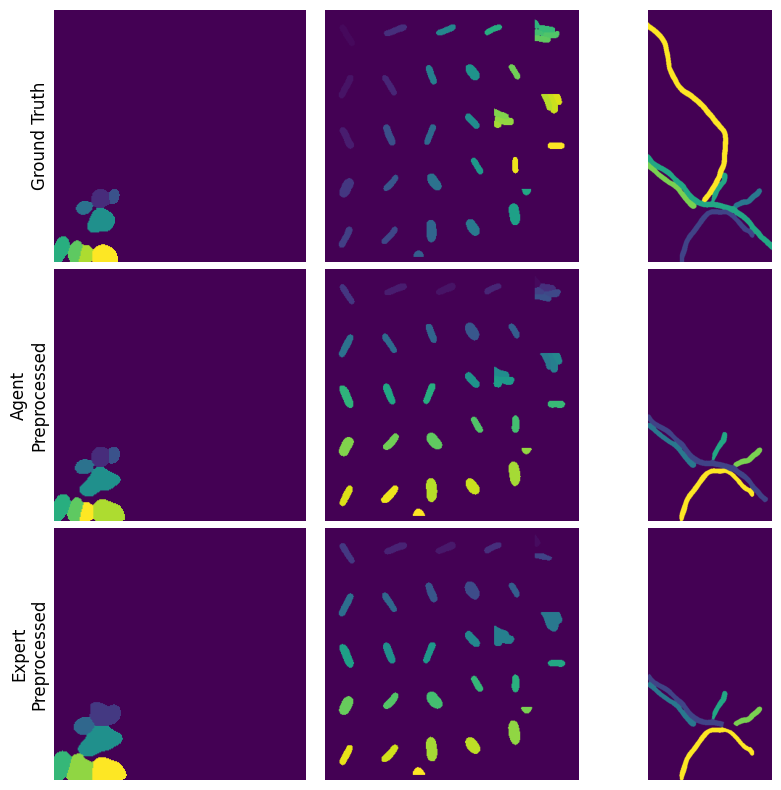

<Figure size 640x480 with 0 Axes>

In [129]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Create figure
fig = plt.figure(figsize=(10, 10))  # Changed from (8, 10) to (10, 10) for consistency

# Create a gridspec with custom width ratios to bring the right column closer
gs = gridspec.GridSpec(3, 3, figure=fig, 
                     width_ratios=[1, 1, 0.9],  # Make the right column slightly narrower
                     wspace=0.03,  # Small space between columns 1-2
                     hspace=0.03)  # Small space between rows

# Define a function to customize each axis the same way
def setup_axis(row, col, img, ylabel=None):
    ax = fig.add_subplot(gs[row, col])
    ax.imshow(img, cmap='viridis')  # Added colormap for better mask visualization
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Remove the spines (borders) for all subplots to reduce spacing
    for spine in ax.spines.values():
        spine.set_visible(False)
        
    if ylabel:
        ax.set_ylabel(ylabel, fontsize=12)
    return ax

# First row: Ground Truth Masks
setup_axis(0, 0, combo_masks[acquired_indices[0]], "Ground Truth")
setup_axis(0, 1, combo_masks[acquired_indices[1]])
setup_axis(0, 2, combo_masks[acquired_indices[2]])

# Second row: Agent Preprocessed Masks
setup_axis(1, 0, preprocessed_masks[acquired_indices[0]], "Agent\nPreprocessed")
setup_axis(1, 1, preprocessed_masks[acquired_indices[1]])
setup_axis(1, 2, preprocessed_masks[acquired_indices[2]])

# Third row: Expert Preprocessed Masks
setup_axis(2, 0, expert_preprocessed_masks[acquired_indices[0]], "Expert\nPreprocessed")
setup_axis(2, 1, expert_preprocessed_masks[acquired_indices[1]])
setup_axis(2, 2, expert_preprocessed_masks[acquired_indices[2]])

# Add space for the y-labels while keeping the figure tight
plt.subplots_adjust(left=0.17, right=0.95)  # Slightly more space for labels

# Add a title to the overall figure
# plt.suptitle("Segmentation Mask Comparison", fontsize=14, y=0.98)

plt.show()
fig = plt.gcf()